# Bayesian Optmisation

Simple Notebook showing how to use  Bayesian Optimisation (BO) to select parameters value using Jane Street Market dataset.

While here I use LGBM, the same logic can be applied to any ML model. It can also be used to define the ANN architecture. The library I will use is *scikit-optimize*. Information on the library and parameters can be found [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html).

The libraries that need to be imported are:

* from skopt import gp_minimize
* from skopt.space import Real, Integer
* from skopt.utils import use_named_args

To keep this short and to the point, I will not extend on how the BO works. If you would like an in depth explanation, I would suggest to read this paper from Peter Frazier (https://arxiv.org/abs/1807.02811). In addition, the set of lectures of [Nando de Freitas](https://www.youtube.com/watch?v=vz3D36VXefI) are extremly valuable and available on Youtube. He also explains Gaussian Process in a marvellous way that blew my mind.

Finally, [Jeff Heaton](https://www.youtube.com/watch?v=sXdxyUCCm8s) has a great example on how to use BO to set the architecture of the ANN.

Ok, let's get started!

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# install datatable
#Model
from lightgbm import LGBMClassifier
#Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Optimisation
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [ ]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

# Data Import

I will skip the EDA analysis, and we will jump straight to the data cleansing, processing and model building phase.

In [ ]:
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')

According to Jane Street Group:
* The set of features, feature_{0...129}, is anonymized and represents real stock market data. Each row is a trading opportunity that we need to predict if the transaction was done (value:1) or not (value: 0).
* As we can see from the above table, each sample has an associated **weight** and **resp**, representing the return on the trade.
* In the test set, the **resp** features are not provided, as it is (or they are) our target feature.
* The **date** feature represents the day of the trade, while **ts_id** represents a time ordering.
* In the datasets, features with **weight = 0** were added. However such trades will not contribute towards the scoring evaluation.

In [ ]:
basic_EDA(train)

Number of Samples: 2390491,
Number of Features: 138,
Duplicated Entries: 0,
Null Entries: 6762701,
Number of Rows with Null Entries: 397119 16.6%


# Data Preparation and Preprocessing

If you participating of this challenge, the steps I taken below are already familiar to you.

* First we create the action column with our binary target. If res > 1 then 1, else is zero.
* Other notebooks have also taken into account resp_1 ... to resp_4. As this is not the goal of this notebook, I will use the simpler approach using only resp as indication of my target
* As a blunt missing values strategy, I am just replacing all by the mean. Other strategies can also be valid and should be investigated
* I have not used any normalisation or standardization strategy for now

In [ ]:
train['action'] = ((train['resp'].values) > 0).astype(int)
train = train[train['weight'] != 0]

features = [c for c in train.columns if 'feature' in c]

for i in features:
    x = train[i].mean()
    train[i] = train[i].fillna(x)


# Model Definition

The way I find easier to work with the GP optimisation library is to create a function that defines the model, calls the dataset, trains and output the score. Ideally, you should be using a validation set to choose the best parameters to avoid overfitting to the test set.

* My test set is the last 100 days of the data. Again, this is an example on how to use the optimiser rather than a how-to win the challenge
* I selected to train and validate with the first 400 days. I will use this timeline to build the training and validation sets
* I am using this simple strategy to focus on the optimisation of the model. Usually, for time series,  you would have more than one window of training and validation sets. And the parameters should be selected according to the ones that give the better result on all time windows

In [ ]:
def model_run(model,train):

    timeframe = 400

    #Creating X
    X = train.copy()
    #Defining the Target
    y = train.loc[:,['action']]

    #Index of training and validation sets
    #I defined 300 days of training and 100 days for validation
    index_train = X['date'] <= (X['date'].max() - 200)
    index_val = (X['date'] > (X['date'].max() - 200)) & (X['date'] <= timeframe)
    index_test = X['date'] > timeframe

    #print(i, X['date'].max()-30, X['date'].max())

    #Removing all other features from X (resp, weight and etc.)
    X = X.loc[:, X.columns.str.contains('feature')]

    #Creating training and validation sets
    X_train = X.loc[index_train]
    y_train = y.loc[index_train]

    X_val = X.loc[index_val]
    y_val = y.loc[index_val]

    X_test = X.loc[index_test]
    y_test = y.loc[index_test]

    #Fitting the model
    model.fit(X_train, y_train.values.ravel(),
                  eval_metric='auc',
                  eval_set=[(X_val, y_val.values.ravel())],
                  verbose=-1)

    #Using AUC score to evaluate results
    AUC_score_val = roc_auc_score(model.predict(X_val),y_val.values.ravel())
    AUC_score_test = roc_auc_score(model.predict(X_test),y_test.values.ravel())

    print("Validation Score: ", AUC_score_val)
    print("Test Score: ", AUC_score_test)

    return AUC_score_val

# Optimisation

Here is where the optimisation bits start. As we are using LGBM, which is a tree based model, I choose the following parameters to be optimised:

* max_depth
* num_leaves
* regularization params: reg_alpha and lambda

The parameters to be optimised needs to be saved within a variable. This variable will be the search space of our optimisation algorithm (hence the name "space").

* Since all the parameters I chosen are non-decimal values, they need to be defined with the word Integer in front, as shown below
* If you want to optimise the learning rate, which is decimal, use Real and check the commented example in the code below

For some reason, it works best if you follow this order when setting up your code (really weird error messages when I tried to change):

1. Define your search space
1. Add **@use_named_args(space)**. This allows the GP opt. to use the params defined in your space variable
1. Create the **objective** function

Since the score I chosen is AUC, which is the higher the better, it is not ideal to be used directly in the BO optimisation function. The BO is trying to minimise the output, as such it will chose the parameter values that actually reduce the AUC if we leave it as it is.

To adapt the AUC score to a minimisation problem, I changed the objective function return output to be **1-AUC Score**. By doing so, the higher the AUC, the smaller the output from the objective function.

In [ ]:
# Algorithm Search Space
space  = [Real(0, 1, name='reg_alpha'),
          Real(0, 1, name='reg_lambda'),
         Integer(10, 500, name = 'max_depth'),
         Integer(10, 500, name = 'num_leaves')]

# For decimal numbers do Real(0.5, 0.9, name='learning_rate')
# Make sure you imported the Real numbers in "from skopt.space import Real, Integer"

# Allows the GP optm to go through your defined search space
@use_named_args(space)

# Function that is going to be called by the optmiser
def objective(**params):
    # Model - I already predefined the basics parameters
    model = LGBMClassifier(objective = 'binary',
                           metric = 'auc',
                           learning_rate = 0.03,
                           early_stopping_round = 50,
                           n_estimators = 10000,
                           verbose = -1)#,
                          #device = 'gpu')

    # Sets the parameters defined by the "space variable"
    model.set_params(**params)

    # Calls my model function that returns the AUC of this
    # parameter configuration

    return 1-(model_run(model,train))

Below is the line of code that calls the GP optmisation. There are more parameters to be defined, however, I find little difference when changing the acquisition function (acq_func) or the optimization method (acq_optimizer), as the default options seemed to work best for this task.

In addition, I would advise to optimise few parameters at a time. While it may seem counterintuitive, in the long run is the best.

To elaborate on the remaining parameters (see full description at [skopt-minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)):

> gp_minimize(func, dimensions, base_estimator=None, n_calls=100, n_random_starts=None, n_initial_points=10, initial_point_generator='random', acq_func='gp_hedge', acq_optimizer='auto', x0=None, y0=None, random_state=None, verbose=False, callback=None, n_points=10000, n_restarts_optimizer=5, xi=0.01, kappa=1.96, noise='gaussian', n_jobs=1, model_queue_size=None)

1. **func**: I named **objective** as it is the function we are trying to minimise. Everytime, the GP will run this function, evaluate the results and select the next set of parameters according to the AUC results;
1. **dimensions**: I named **space**. This is the available search space, where the range of the features are defined.
1. **n_calls**: Number of times the GP optm will run to find the best results. I would not leave the default as it takes a long time for this dataset. Increase as you gain more confidence with the process. The GP optm advantage is that is converges rapidly to a good enough solution when compared to other optmisation algorithms. As such, it has been widely used for complex problems that cannot afford to be run 500x.
1. **n_initial_points**: To define the best way forward, the GP optm will first run in some random points within the feature space. After this X number of runs, it will define the best "next" point to be evaluated and run for the next **n_calls**.


In [ ]:
res_gp = gp_minimize(objective, space, n_calls=20, n_initial_points = 10, random_state=0)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[189]	valid_0's auc: 0.521348
Validation Score:  0.5155145386896727
Test Score:  0.5165621571288116


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.519491
Validation Score:  0.5144733357030515
Test Score:  0.5137309089412098


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.522502
Validation Score:  0.5158425716250896
Test Score:  0.5162443558930311


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.522234
Validation Score:  0.5161964637610547
Test Score:  0.5172481809397993


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.521821
Validation Score:  0.515703785901993
Test Score:  0.5165148247322521


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.524123
Validation Score:  0.517292032310819
Test Score:  0.5174146416363742


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.522645
Validation Score:  0.516427324230639
Test Score:  0.5158513854251121


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.520885
Validation Score:  0.5155458516785083
Test Score:  0.5181154120189674


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid_0's auc: 0.523692
Validation Score:  0.5175081994753848
Test Score:  0.5168926523469063


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's auc: 0.521653
Validation Score:  0.5153891743788558
Test Score:  0.5161535188021609


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.521071
Validation Score:  0.5150594827071574
Test Score:  0.5134630797671894


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's auc: 0.52258
Validation Score:  0.5164330485183112
Test Score:  0.517921322061715


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.522586
Validation Score:  0.5169280187767898
Test Score:  0.5177375919329478


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[342]	valid_0's auc: 0.523061
Validation Score:  0.5166623743460889
Test Score:  0.5167224163001337


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.523014
Validation Score:  0.5172005346192524
Test Score:  0.5170802534534814


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	valid_0's auc: 0.52413
Validation Score:  0.517346018632677
Test Score:  0.5173264959637617


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[453]	valid_0's auc: 0.524353
Validation Score:  0.5174635376946396
Test Score:  0.517954367289677


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.523343
Validation Score:  0.5171192986549951
Test Score:  0.517449239047174


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.521847
Validation Score:  0.5161813796485107
Test Score:  0.5171663532040602


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.524215
Validation Score:  0.5170653248371054
Test Score:  0.5168203005353238


In [ ]:
print("Best score=%.4f" % (1-res_gp.fun))

print("""Best parameters:
- reg_alpha = %.2f
- reg_lambda = %.2f
- max_depth = %d
- num_leaves = %d""" % (res_gp.x[0], res_gp.x[1],res_gp.x[2], res_gp.x[3]))

Best score=0.5175
Best parameters:
- reg_alpha = 0.22
- reg_lambda = 0.14
- max_depth = 169
- num_leaves = 83


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

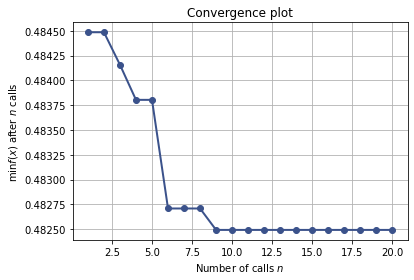

In [ ]:
#If you would like to plot the results

from skopt.plots import plot_convergence

plot_convergence(res_gp)

From the convergence plot we can see that there is not much gain after 20 rounds of optimisation. As such, we could reduce the number of iterations (n_calls) from **20** to **10** to speed up the optimisation process.

# Create final Optimised Model

Below we use the output of the BO to define our final model. GPU is turned off as I am using for another Kaggle window :)

In [ ]:
params = {
'objective': 'binary',
"metric": "auc",
"learning_rate": 0.03,
"reg_lambda":res_gp.x[0],
"reg_alpha": res_gp.x[1],
"max_depth": res_gp.x[2],
"num_leaves": res_gp.x[3],
"n_estimators": 350,
"boosting_type":"gbdt",
'random_state': 0,
#"device": "gpu"
}

Now instead of using training and validation sets, we make the most of the data made available. We train the whole model again, now with the final parameters defined by the optimiser.

In [ ]:
model = LGBMClassifier()
model.set_params(**params)

#Now that  we use the whole data to train and create final model

X = train.copy()
#Defining the Target
y = train.loc[:,['action']]

X = X.loc[:, X.columns.str.contains('feature')]

#Fitting the model
model.fit(X,y.values.ravel())

#Using AUC score to evaluate results
AUC_score = roc_auc_score(model.predict(X),y.values.ravel())

#The score is higher as it is based on a training set
#but is just to give an overall idea
print("AUC Score: ", AUC_score)

AUC Score:  0.5797744168456851


During the parameter optimisation phase, I set the n_estimators very high (10.000) as the early stopping would control and avoid overfitting. For the final model, I used n_estimators = 350 instead as I am not using early_stopping to avoid overfitting. I did not use early_stopping as it requires the usage of a validation set and I wanted to train the model with the full data.

Try to optmise the n_estimators. Otherwise, use a subset as the validation set and use early stopping. Also, perhaps focusing more effort on regularization parameters and feature engineering are the way to go.

Hopefully this has been helpful. I am happy that some people upvoted, thank you!